In [52]:
# Libraries

import matplotlib.pyplot as plt
import pandas as pd
import torch

# Preliminaries

from torchtext.data import Field, TabularDataset, BucketIterator, Iterator

# Models

import torch.nn as nn
from transformers import BertTokenizer, BertForSequenceClassification, BertConfig

# Training

import torch.optim as optim

# other stuff

import re
from sklearn.model_selection import train_test_split

In [53]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
print(device)

cuda:0


### Load in the training and validation/test data here:

In [54]:
## TODO

train_data = pd.read_csv('../data/EQ2-Data/covid_train.csv')
valid_data = pd.read_csv('../data/EQ2-Data/news_test.csv')

In [55]:
## remove null values

train_data = train_data[~train_data['text'].isna()][['text','label']]
valid_data = valid_data[~valid_data['text'].isna()][['text','label']]

In [56]:
tokenizer = BertTokenizer.from_pretrained('bert-base-cased')

In [57]:
## check dataframe info

train_data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 6000 entries, 0 to 5999
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   text    6000 non-null   object 
 1   label   6000 non-null   float64
dtypes: float64(1), object(1)
memory usage: 140.6+ KB


In [58]:
valid_data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2000 entries, 0 to 1999
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   text    2000 non-null   object 
 1   label   2000 non-null   float64
dtypes: float64(1), object(1)
memory usage: 46.9+ KB


In [59]:
## pre-processing

def text_cleaning(text):
    text = re.sub("[^a-zA-Z]", " ", text) # removing punctuation
    return text

train_data['text'] = train_data['text'].apply(text_cleaning)
valid_data['text'] = valid_data['text'].apply(text_cleaning)

In [60]:
# splitting validation into validation and test

val_split, test_split = train_test_split(valid_data,test_size = 0.5)

In [61]:
## save preprocessed splits into csv (TODO: add path)

train_data.to_csv("../data/EQ2-Data/processed_splits/covid_train.csv", index=False)
val_split.to_csv("../data/EQ2-Data/processed_splits/news_valid.csv", index=False)
test_split.to_csv("../data/EQ2-Data/processed_splits/news_test.csv", index=False)

In [62]:
# Model parameter
MAX_SEQ_LEN = 256
PAD_INDEX = tokenizer.convert_tokens_to_ids(tokenizer.pad_token)
UNK_INDEX = tokenizer.convert_tokens_to_ids(tokenizer.unk_token)

In [63]:
## Data loader

# Fields

label_field = Field(sequential=False, use_vocab=False, batch_first=True, dtype=torch.float)
text_field = Field(use_vocab=False, tokenize=tokenizer.encode, lower=False, include_lengths=False, batch_first=True,
                   fix_length=MAX_SEQ_LEN, pad_token=PAD_INDEX, unk_token=UNK_INDEX)
fields = [('text', text_field), ('label', label_field)]

# TabularDataset (TODO: add path)

train, valid, test = TabularDataset.splits(path="../data/EQ2-Data/processed_splits/", train='covid_train.csv', validation='news_valid.csv',
                                           test='news_test.csv', format='CSV', fields=fields, skip_header=True)
# file names above are the ones you used to save the prepocessed csvs

# Iterators

train_iter = BucketIterator(train, batch_size=16, sort_key=lambda x: len(x.text),
                            device=device, train=True, sort=True, sort_within_batch=True)
valid_iter = BucketIterator(valid, batch_size=16, sort_key=lambda x: len(x.text),
                            device=device, train=True, sort=True, sort_within_batch=True)
test_iter = Iterator(test, sort_key = None, batch_size=16, device=device, train=False, shuffle=False, sort=False)

Token indices sequence length is longer than the specified maximum sequence length for this model (2209 > 512). Running this sequence through the model will result in indexing errors


KeyboardInterrupt: 

In [ ]:
class BERT(nn.Module):

    def __init__(self):
        super(BERT, self).__init__()

        options_name = "bert-base-cased"
        self.encoder = BertForSequenceClassification.from_pretrained(options_name, num_labels=2)

    def forward(self, text, label=None):
        
        if label is not None:
            loss, text_fea = self.encoder(text, output_hidden_states=True, labels=label)[:2]

            return loss, text_fea
        
        else:
            return self.encoder(text)

In [ ]:
# Save and Load Functions

def save_checkpoint(save_path, model, valid_loss):

    if save_path == None:
        return
    
    state_dict = {'model_state_dict': model.state_dict(),
                  'valid_loss': valid_loss}
    
    torch.save(state_dict, save_path)
    print(f'Model saved to ==> {save_path}')

def load_checkpoint(load_path, model, device):
    
    if load_path==None:
        return
    
    state_dict = torch.load(load_path, map_location=device)
    print(f'Model loaded from <== {load_path}')
    
    model.load_state_dict(state_dict['model_state_dict'])
    #return state_dict['valid_loss']
    return model

def save_metrics(save_path, train_loss_list, valid_loss_list, global_steps_list):

    if save_path == None:
        return
    
    state_dict = {'train_loss_list': train_loss_list,
                  'valid_loss_list': valid_loss_list,
                  'global_steps_list': global_steps_list}
    
    torch.save(state_dict, save_path)
    print(f'Model saved to ==> {save_path}')


def load_metrics(load_path, device):

    if load_path==None:
        return
    
    state_dict = torch.load(load_path, map_location=device)
    print(f'Model loaded from <== {load_path}')
    
    return state_dict['train_loss_list'], state_dict['valid_loss_list'], state_dict['global_steps_list']

In [ ]:
# Training Function

def train(model,
          optimizer,
          criterion = nn.BCELoss(),
          train_loader = train_iter,
          valid_loader = valid_iter,
          num_epochs = 5,
          eval_every = len(train_iter) // 2,
          file_path = "./",
          best_valid_loss = float("Inf")):
    
    # initialize running values
    running_loss = 0.0
    valid_running_loss = 0.0
    global_step = 0
    train_loss_list = []
    valid_loss_list = []
    global_steps_list = []

    # training loop
    model.train()
    for epoch in range(num_epochs):
        for (text, labels), _ in train_loader:
            labels = labels.type(torch.LongTensor)           
            labels = labels.to(device)
            text = text.type(torch.LongTensor)
            text = text.to(device)
            output = model(text, labels)
            loss, _ = output

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            # update running values
            running_loss += loss.item()
            global_step += 1

            # evaluation step
            if global_step % eval_every == 0:
                model.eval()
                with torch.no_grad():                    

                    # validation loop
                    for (text, labels), _ in valid_loader:
                        labels = labels.type(torch.LongTensor)           
                        labels = labels.to(device)
                        text = text.type(torch.LongTensor)  
                        text = text.to(device)
                        output = model(text, labels)
                        loss, _ = output
                        
                        valid_running_loss += loss.item()

                # evaluation
                average_train_loss = running_loss / eval_every
                average_valid_loss = valid_running_loss / len(valid_loader)
                train_loss_list.append(average_train_loss)
                valid_loss_list.append(average_valid_loss)
                global_steps_list.append(global_step)

                # resetting running values
                running_loss = 0.0                
                valid_running_loss = 0.0
                model.train()

                # print progress
                print('Epoch [{}/{}], Step [{}/{}], Train Loss: {:.4f}, Valid Loss: {:.4f}'
                      .format(epoch+1, num_epochs, global_step, num_epochs*len(train_loader),
                              average_train_loss, average_valid_loss))
                
                # checkpoint
                if best_valid_loss > average_valid_loss:
                    best_valid_loss = average_valid_loss
                    save_checkpoint(file_path + '/' + 'model.pt', model, best_valid_loss)
                    save_metrics(file_path + '/' + 'model_metrics.pt', train_loss_list, valid_loss_list, global_steps_list)
    
    save_metrics(file_path + '/' + 'model_metrics.pt', train_loss_list, valid_loss_list, global_steps_list)
    print('Finished Training!')

In [ ]:
## to avoid CUDA memory error

torch.cuda.empty_cache()

import gc
#del variables
gc.collect()

2925

In [ ]:
model = BERT().to(device)
optimizer = optim.Adam(model.parameters(), lr=2e-5)

train(model=model, optimizer=optimizer)

Some weights of the model checkpoint at bert-base-cased were not used when initializing BertForSequenceClassification: ['cls.predictions.transform.dense.bias', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.weight', 'cls.predictions.bias', 'cls.predictions.decoder.weight']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at b

Epoch [1/5], Step [187/1875], Train Loss: 0.0741, Valid Loss: 2.7679
Model saved to ==> .//model.pt
Model saved to ==> .//model_metrics.pt
Epoch [1/5], Step [374/1875], Train Loss: 0.0645, Valid Loss: 3.2187
Epoch [2/5], Step [561/1875], Train Loss: 0.1585, Valid Loss: 2.8770
Epoch [2/5], Step [748/1875], Train Loss: 0.1193, Valid Loss: 3.0761
Epoch [3/5], Step [935/1875], Train Loss: 0.1438, Valid Loss: 2.7217
Model saved to ==> .//model.pt
Model saved to ==> .//model_metrics.pt
Epoch [3/5], Step [1122/1875], Train Loss: 0.1134, Valid Loss: 2.7516
Epoch [4/5], Step [1309/1875], Train Loss: 0.1576, Valid Loss: 2.5177
Model saved to ==> .//model.pt
Model saved to ==> .//model_metrics.pt
Epoch [4/5], Step [1496/1875], Train Loss: 0.1152, Valid Loss: 2.2927
Model saved to ==> .//model.pt
Model saved to ==> .//model_metrics.pt
Epoch [5/5], Step [1683/1875], Train Loss: 0.1326, Valid Loss: 2.4687
Epoch [5/5], Step [1870/1875], Train Loss: 0.0917, Valid Loss: 2.0233
Model saved to ==> .//mod

Model loaded from <== ./model_metrics.pt


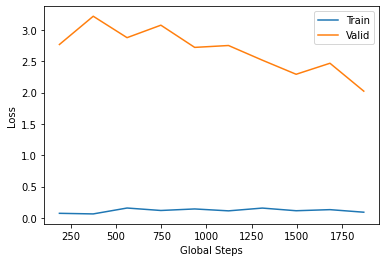

In [71]:
destination_folder = "." # TODO: check that this is where your saved model is
train_loss_list, valid_loss_list, global_steps_list = load_metrics(destination_folder + '/model_metrics.pt', device)
plt.plot(global_steps_list, train_loss_list, label='Train')
plt.plot(global_steps_list, valid_loss_list, label='Valid')
plt.xlabel('Global Steps')
plt.ylabel('Loss')
plt.legend()
plt.show() 

In [65]:
# Evaluation
import sklearn.metrics as metrics
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import seaborn as sns

In [74]:
# Evaluation Function

def evaluate(model, test_loader):
    y_pred = []
    y_true = []

    model.eval()
    with torch.no_grad():
        for (text, labels), _ in test_loader:

                labels = labels.type(torch.LongTensor)           
                labels = labels.to(device)
                
                text = text.type(torch.LongTensor)  
                text = text.to(device)
                
                output = model(text, labels)
                #output = model(text)
                _, output = output
                y_pred.extend(torch.argmax(output, 1).tolist())
                y_true.extend(labels.tolist())
    
    print('Classification Report:')
    print(classification_report(y_true, y_pred, labels=[1,0], digits=4))
    
    cm = confusion_matrix(y_true, y_pred, labels=[1,0])
    ax= plt.subplot()
    sns.heatmap(cm, annot=True, ax = ax, cmap='Blues', fmt="d")

    ax.set_title('Confusion Matrix')

    ax.set_xlabel('Predicted Labels')
    ax.set_ylabel('True Labels')

    ax.xaxis.set_ticklabels(['FAKE', 'REAL'])
    ax.yaxis.set_ticklabels(['FAKE', 'REAL'])
    
    ## for ROC curve:
    fpr, tpr, thresholds = metrics.roc_curve(y_true, y_pred)
    roc_auc = metrics.auc(fpr, tpr)
    display = metrics.RocCurveDisplay(fpr=fpr, tpr=tpr, roc_auc=roc_auc)
    display.plot(name="add-some-name-here") 
    plt.show() 

In [75]:
## to avoid CUDA memory error

torch.cuda.empty_cache()

import gc
#del variables
gc.collect()

3771

In [76]:
MODEL_NAME = "/model.pt"  #change accordingly

Some weights of the model checkpoint at bert-base-cased were not used when initializing BertForSequenceClassification: ['cls.predictions.transform.dense.bias', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.weight', 'cls.predictions.bias', 'cls.predictions.decoder.weight']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at b

Model loaded from <== ./model.pt


/home/local/ASUAD/sbhambr1/anaconda3/envs/diml-bert/lib/python3.7/site-packages/torchtext/data/batch.py:23: UserWarning: Batch class will be retired soon and moved to torchtext.legacy. Please see the most recent release notes for further information.
  warnings.warn('{} class will be retired soon and moved to torchtext.legacy. Please see the most recent release notes for further information.'.format(self.__class__.__name__), UserWarning)


Classification Report:
              precision    recall  f1-score   support

           1     0.8333    0.0103    0.0204       485
           0     0.5171    0.9981    0.6812       515

    accuracy                         0.5190      1000
   macro avg     0.6752    0.5042    0.3508      1000
weighted avg     0.6705    0.5190    0.3607      1000



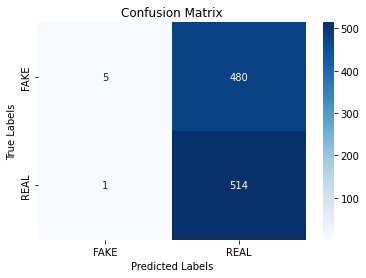

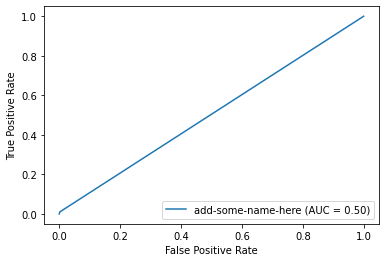

In [77]:
best_model = BERT().to(device)

loaded_model = load_checkpoint(load_path=destination_folder + MODEL_NAME, model = best_model, device=device)
evaluate(loaded_model, test_iter)